# eDISH Plot

## load packages

In [1]:
library(tidyverse)
library(haven)
library(Cairo)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## set working directory

In [2]:
setwd("/mnt/imported/data/ADAM")


## load data

In [3]:
adlbhy <- read_sas("adlbhy.sas7bdat")

## eDISH Plot

#### taking the max AVAL by USUBJID for max ALT

### make the ALT data

In [4]:
adlbhy_alt <- adlbhy %>%
  filter(ANL01FL == "Y" & PARAMCD == "ALT")  %>%
  group_by(USUBJID) %>%
  mutate(max_aval = max(AVAL),
         max_ALT_ULN = max(R2A1HI)) %>%
  ungroup()

In [5]:
### make the BILI data

In [6]:
adlbhy_bili_pre <- adlbhy %>%
  filter(ANL01FL == "Y" & PARAMCD == "BILI")  %>%
  group_by(USUBJID) %>%
  mutate(max_aval = max(AVAL),
         max_BILI_ULN = max(R2A1HI)) %>%
  ungroup()

#### keep only needed variables

In [7]:
adlbhy_bili <- adlbhy_bili_pre[,c("USUBJID", "AVISITN", "max_BILI_ULN")]

### merge all together

In [8]:
edish_data_prep <- merge(adlbhy_alt, adlbhy_bili, by = c("USUBJID", "AVISITN"), all = TRUE)

## make eDISH plot

#### find the unique data for each subject

In [9]:
edish_data_unique <- unique(edish_data_prep[,c("USUBJID",  "max_ALT_ULN",  "max_BILI_ULN")])

#### find the number of patients that fall within each bound

In [10]:
edish_summary_prep <- edish_data_unique %>%
  mutate(status = ifelse(max_ALT_ULN < 1 & max_BILI_ULN < 1, "Normal",
                         ifelse(max_ALT_ULN < 3 & max_BILI_ULN < 2 & max_ALT_ULN >= 1 , "",
                                ifelse(max_ALT_ULN < 3 & max_BILI_ULN < 2 & max_BILI_ULN >= 1, "",
                                       ifelse(max_ALT_ULN >= 3 & max_BILI_ULN >= 2, "Hy's Law",
                                              ifelse(max_ALT_ULN < 3 & max_BILI_ULN >= 2, "Hyperbilirubinemia",
                                                     ifelse(max_ALT_ULN >= 3 & max_BILI_ULN < 2, "Temple's Corollary",
                                                            NA))))))) %>%
  group_by(status) %>%
  summarise(USUBJID, 
            max_ALT_ULN,
            max_BILI_ULN,
            n = n()) %>%
  ungroup()

`summarise()` has grouped output by 'status'. You can override using the
`.groups` argument.


#### if any counts = 0, that status will not appear.  Merge this on to make 0 appear

In [11]:
status_all <- data.frame(status = c("Normal", "", "Hy's Law", "Hyperbilirubinemia", "Temple's Corollary"),
                         n_0 = rep(0,5))

edish_summary_pre <- merge(edish_summary_prep, status_all, by = "status", all = TRUE) 

edish_summary <- edish_summary_pre %>%
  summarise(USUBJID,
            status,
            n = ifelse(is.na(n) == TRUE, 0, n),
            x_lab = ifelse(status == "Normal", floor(min(max_ALT_ULN)), 
                           ifelse(status == "", 1,
                                  ifelse(status == "Hy's Law", 3,
                                         ifelse(status == "Hyperbilirubinemia",  floor(min(max_ALT_ULN)),
                                                ifelse(status == "Temple's Corollary", 3, NA))))),
            y_lab = ifelse(status == "Normal", floor(min(max_BILI_ULN)), 
                           ifelse(status == "", floor(min(max_BILI_ULN)),
                                  ifelse(status == "Hy's Law", 2,
                                         ifelse(status == "Hyperbilirubinemia", 2,
                                                ifelse(status == "Temple's Corollary", floor(min(max_BILI_ULN)),
                                                       NA))))))

#### get just the unique counts for status to be used as text on plot

In [12]:
status_count <- unique(edish_summary[,c("status", "n", "x_lab", "y_lab")])


#### merge onto edish_data_prep to make edish_data

In [13]:
edish_data <- merge(edish_data_prep, edish_summary, by = "USUBJID", all = TRUE)

## the edish plot

#### save and output as a PDF

In [14]:
setwd("/mnt/artifacts/results")

In [15]:
# pdf(file = "edish_jupyter.pdf", height = 8, width = 14)

#### plot

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


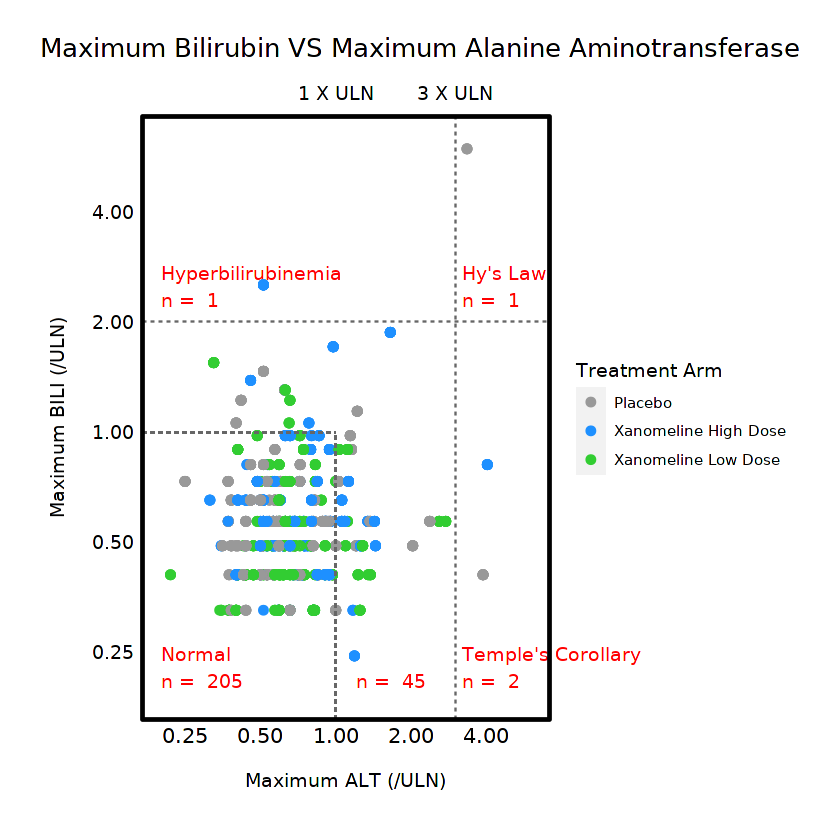

In [16]:
ggplot(data = edish_data) +
  
  # add labels of number in each status
  geom_text(data = status_count,
            aes(x = x_lab + 0.2,
                y = y_lab + 0.2),
            label = paste(status_count$status, "\nn = ", status_count$n),
            hjust = -0,
            vjust = -0,
            col = "red") +
  
  # scatter points
  geom_point(aes(x = max_ALT_ULN,
                 y = max_BILI_ULN,
                 color = TRTA),
             size = 2) +
  
  # set point colours
  scale_color_manual(values = c("grey60", "dodgerblue", "limegreen"),
                     name = "Treatment Arm") +
  
  # line of lower limit (requires two lines)
  geom_segment(aes(x = 1,
                   xend = 1,
                   y = 0,
                   yend = 1),
               linetype = "dashed",
               col = "grey40") +
  geom_segment(aes(x = 0,
                   xend = 1,
                   y = 1,
                   yend = 1),
               linetype = "dashed",
               col = "grey40") +
  
  # line of upper limit 
  geom_hline(aes(yintercept = 2),
             linetype = "dashed",
             col = "grey40") +
  geom_vline(aes(xintercept = 3),
             linetype = "dashed",
             col = "grey40") +
  
  # annotate outside of plot where 1 X ULN and 3 X ULN for ALT
  annotate("text",
           x = c(1,3),
           y = c(max(max(edish_data$max_BILI_ULN),4) + 2.5,
                 max(max(edish_data$max_BILI_ULN), 4) + 2.5),
           label = c("1 X ULN", "3 X ULN")
  ) +
  
  # set axis limits 
  coord_cartesian(ylim = c(min(edish_data$max_BILI_ULN) - 0.05,
                           max(edish_data$max_BILI_ULN) + 0.2),
                  clip = "off") +
  
  # axis labels 
  labs(x = "Maximum ALT (/ULN)",
       y = "Maximum BILI (/ULN)",
       title = "Maximum Bilirubin VS Maximum Alanine Aminotransferase") +
  
  # set log scales for x an y axis, 
  scale_x_continuous(trans='log2') +
  scale_y_continuous(trans='log2') +
  expand_limits(x=c(0, 6), y= c(0, 4)) + # the smallest axis limits given, but will be bigger if data points are
  
  # theme
  theme( strip.background = element_blank(),
         # legend.position = "none",
         axis.line = element_line(colour = "black"),
         axis.ticks = element_blank(),
         strip.text = element_text(size = 8,
                                   margin = margin(b = 5)),
         panel.background = element_rect(fill = "white"),
         panel.border = element_rect(colour = "black", fill=NA, size=1),
         #panel.grid = element_line(colour = "black"),
         plot.title = element_text(size = 15,
                                   hjust = 0.5,
                                   vjust = 10),
         plot.margin = margin(50, 30, 30, 30),
         plot.title.position = 'plot',
         panel.spacing = unit(0.2, 'in'),
         axis.title.x = element_text(size = 11,
                                     margin = margin(t = 15),
                                     color = "black"),
         axis.title.y = element_text(size = 11,
                                     margin = margin(r = 15),
                                     color = "black"),
         plot.subtitle = element_text(size = 11,
                                      margin = margin(b = 15)),
         axis.text.x = element_text(size = 12,
                                    color = "black"),
         axis.text.y = element_text(size = 11,
                                    color = "black",
                                    hjust = 0))

In [17]:
dev.off() # Closes the plot and saves it as file

null device 
          1

In [18]:
edish_data

USUBJID,AVISITN,STUDYID,SITEID,SAFFL,TRTA,TRTAN,ADT,ADTM,ADY,⋯,LVOTFL,CRIT1,CRIT1FL,max_aval,max_ALT_ULN,max_BILI_ULN,status,n,x_lab,y_lab
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<date>,<dttm>,<dbl>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>
01-701-1015,10,CDISCPILOT01,701,Y,Placebo,0,2014-05-07,2014-05-07 11:21:00,126,⋯,,R2A1HI>1.5,N,41,1.2058824,0.4885714,,45,1,0
01-701-1015,11,CDISCPILOT01,701,Y,Placebo,0,2014-05-21,2014-05-21 10:58:00,140,⋯,,R2A1HI>1.5,N,41,1.2058824,0.4885714,,45,1,0
01-701-1015,12,CDISCPILOT01,701,Y,Placebo,0,2014-06-18,2014-06-18 13:00:00,168,⋯,Y,R2A1HI>1.5,N,41,1.2058824,0.4885714,,45,1,0
01-701-1015,13,CDISCPILOT01,701,Y,Placebo,0,2014-07-02,2014-07-02 11:45:00,182,⋯,,R2A1HI>1.5,N,41,1.2058824,0.4885714,,45,1,0
01-701-1015,3,CDISCPILOT01,701,Y,Placebo,0,2013-12-26,2013-12-26 14:45:00,-7,⋯,,R2A1HI>1.5,N,41,1.2058824,0.4885714,,45,1,0
01-701-1015,4,CDISCPILOT01,701,Y,Placebo,0,2014-01-16,2014-01-16 13:17:00,15,⋯,,R2A1HI>1.5,N,41,1.2058824,0.4885714,,45,1,0
01-701-1015,5,CDISCPILOT01,701,Y,Placebo,0,2014-01-30,2014-01-30 08:50:00,29,⋯,,R2A1HI>1.5,N,41,1.2058824,0.4885714,,45,1,0
01-701-1015,601,CDISCPILOT01,701,Y,Placebo,0,2014-06-18,2014-06-18 13:00:00,168,⋯,Y,R2A1HI>1.5,N,41,1.2058824,0.4885714,,45,1,0
01-701-1015,7,CDISCPILOT01,701,Y,Placebo,0,2014-02-12,2014-02-12 12:56:00,42,⋯,,R2A1HI>1.5,N,41,1.2058824,0.4885714,,45,1,0


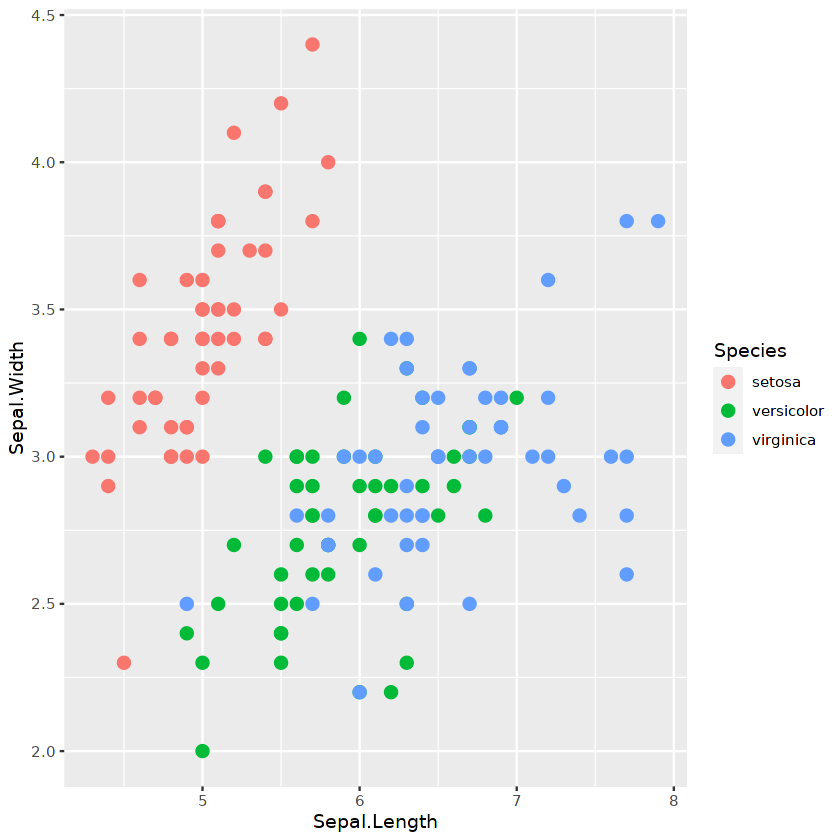

In [19]:
ggplot(data=iris, aes(x=Sepal.Length, y=Sepal.Width, color=Species)) + geom_point(size=3)